
#**Student_Performance_Predictor_for_EduQuest_Coaching**

This project focuses on building a predictive model to identify students who may need academic support.
It uses regression to predict scores and classification to categorize student performance.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
# XGBoost
try:
    from xgboost import XGBRegressor
    xgb_installed = True
except ImportError:
    xgb_installed = False

In [ ]:
# Step 1: Load the dataset
file_path = "Student Performance Predictor for EduQuest Coaching.csv"
df = pd.read_csv(file_path)

In [ ]:
# Step 2: Encode categorical features to numerical values
# Many ML algorithms don't handle strings, so there is need to encode them
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

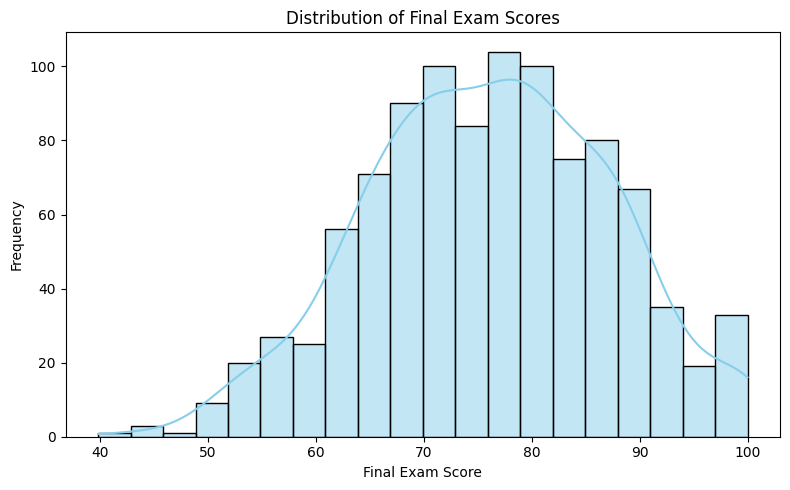

In [ ]:
# Step 3: Visual Insights to understand data patterns
# These plots help spot trends, outliers, or relationships
plt.figure(figsize=(8, 5))
sns.histplot(df['final_exam_score'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Final Exam Scores")
plt.xlabel("Final Exam Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Most students score between 60-90. There is a small number of high scorers (above 90), and a noticeable tail in lower scores.


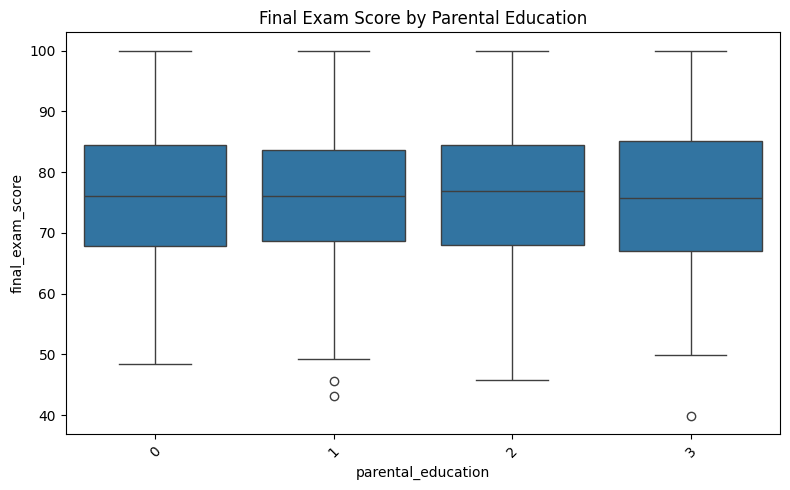

In [ ]:
# Checking if parental education influences scores
plt.figure(figsize=(8, 5))
sns.boxplot(x='parental_education', y='final_exam_score', data=df)
plt.title("Final Exam Score by Parental Education")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Students with higher parental education tend to have higher scores. This suggests that educational background at home plays a role.


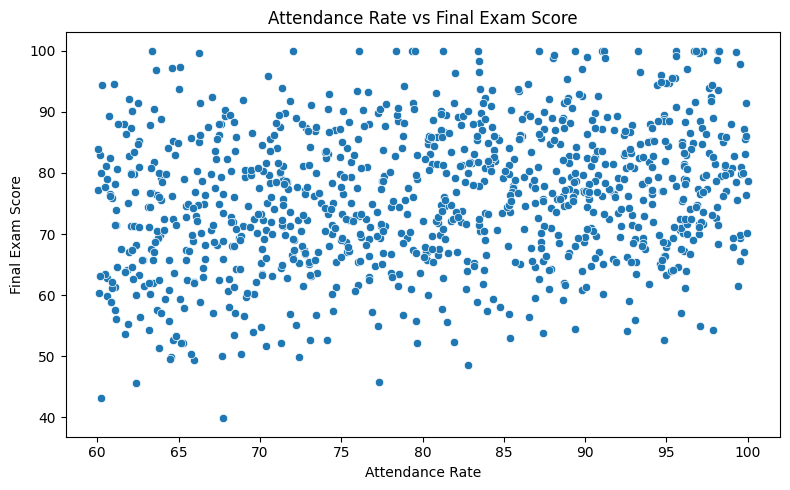

In [ ]:
# Investigating whether better attendance leads to better performance
plt.figure(figsize=(8, 5))
sns.scatterplot(x='attendance_rate', y='final_exam_score', data=df)
plt.title("Attendance Rate vs Final Exam Score")
plt.xlabel("Attendance Rate")
plt.ylabel("Final Exam Score")
plt.tight_layout()
plt.show()

A general upward trend indicates that students with better attendance often perform better in exams.


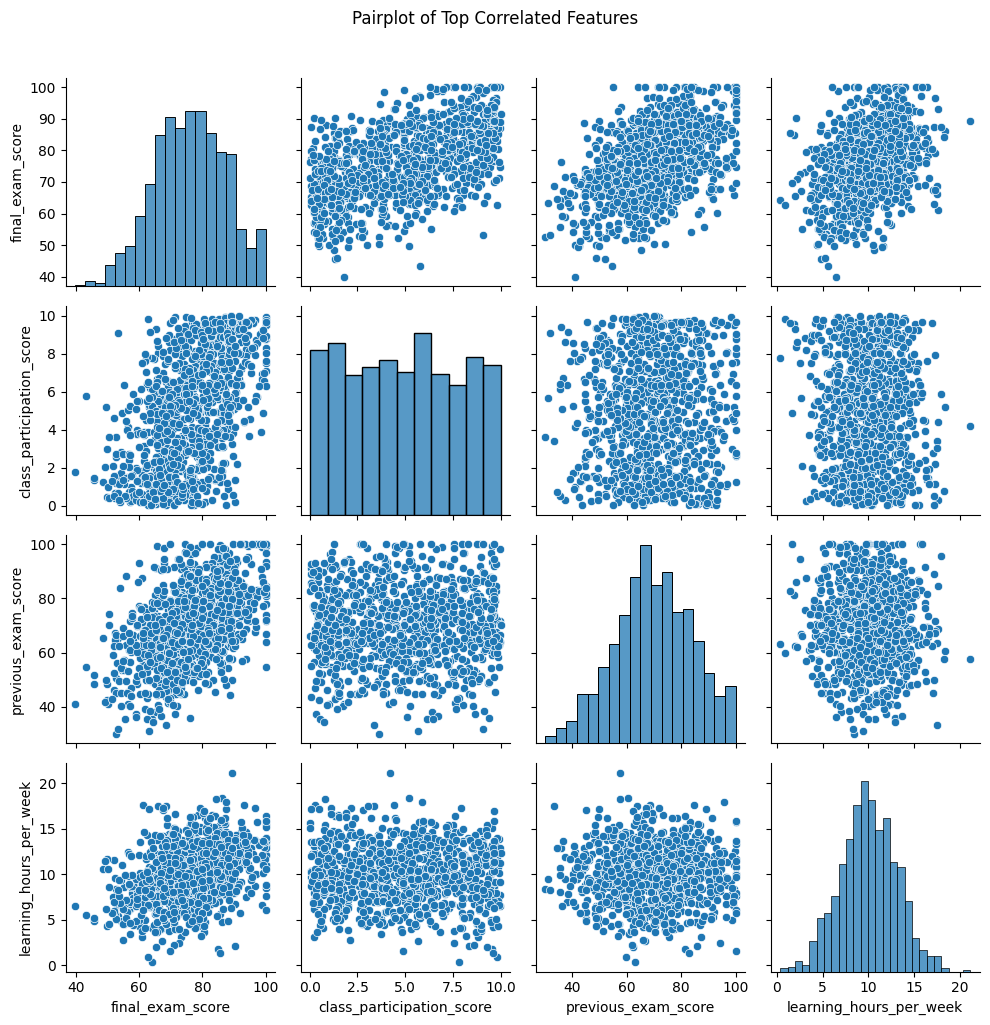

In [ ]:
# Check for multivariate relationships
top_features = df[['final_exam_score', 'class_participation_score', 'previous_exam_score', 'learning_hours_per_week']]
sns.pairplot(top_features)
plt.suptitle("Pairplot of Top Correlated Features", y=1.02)
plt.tight_layout()
plt.show()

Strong correlations can be seen between previous exam scores, participation, and final results. These features are good predictors.


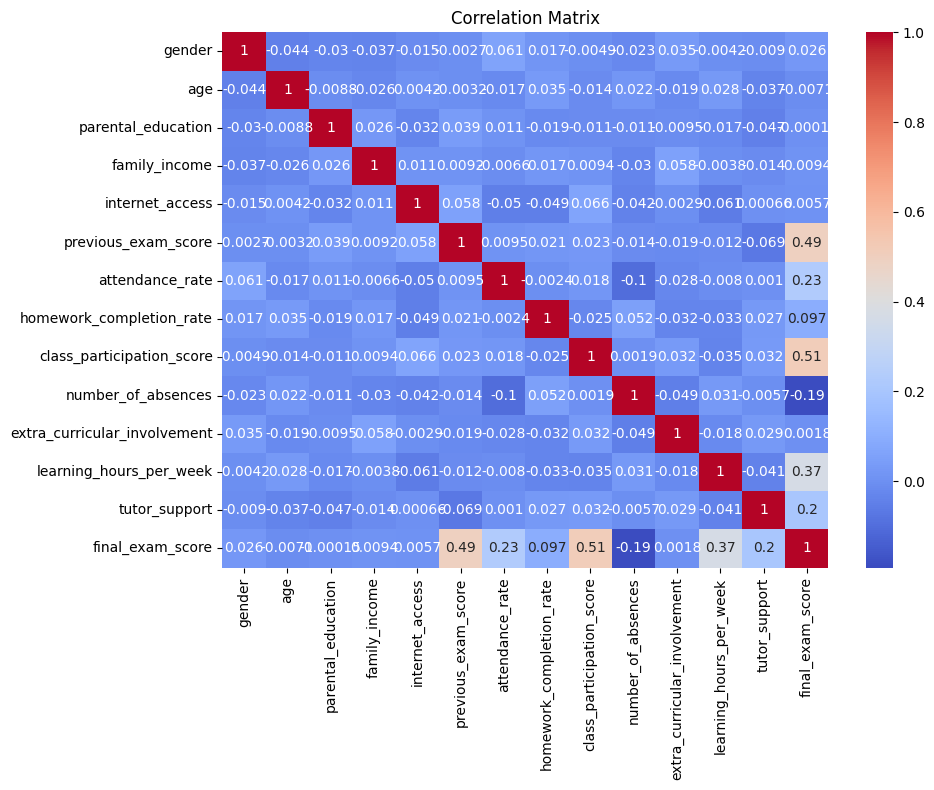

In [ ]:
# Step 4: Correlation matrix to identify how strongly variables relate to one another
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

High correlation between past academic performance and final score. Other contributing factors include participation and learning hours.

In [ ]:
# Step 5: Prepare features and target for regression model
# Predict 'final_exam_score' based on other features
X = df.drop('final_exam_score', axis=1)
y = df['final_exam_score']

In [ ]:
# Step 6: Standardize features to bring everything to a similar scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Step 7: Train-test split to evaluate models properly
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Step 8: Model Comparison Dashboard
# Trying multiple models to see which one fits the data best
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}
if xgb_installed:
    models['XGBoost'] = XGBRegressor(objective='reg:squarederror', random_state=42)

results = []

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    elapsed = time.time() - start_time

    # 5-fold Cross-validation for generalization check
    scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=5)
    mean_cv_r2 = scores.mean()

    results.append({
        'Model': name,
        'MSE': round(mse, 2),
        'R2 Score': round(r2, 2),
        'CV R2': round(mean_cv_r2, 2),
        'Time (s)': round(elapsed, 2)
    })

In [ ]:
# Display results in descending order of R2 score
results_df = pd.DataFrame(results).sort_values(by='R2 Score', ascending=False)
print("\nModel Comparison:")
print(results_df.to_string(index=False))


Model Comparison:
           Model   MSE  R2 Score  CV R2  Time (s)
LinearRegression 31.05      0.77   0.79      0.05
    RandomForest 41.54      0.69   0.68      1.88
             SVR 44.33      0.67   0.69      0.05
         XGBoost 43.61      0.67   0.69      0.26


In [ ]:
# Step 9: Feature importance from the best-performing model
# Finding which features influence student performance the most
model = models['RandomForest']
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

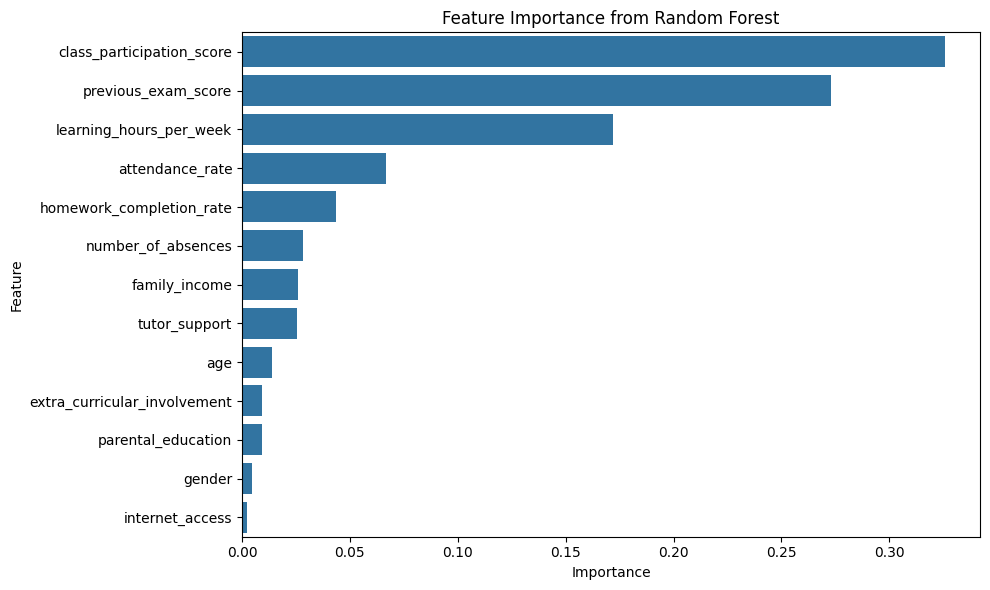

In [ ]:
# Step 10: Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
plt.title("Feature Importance from Random Forest")
plt.tight_layout()
plt.show()

Features like previous_exam_score and class_participation_score are highly influential in determining final performance.

In [ ]:
# Step 11: Classify performance levels to identify students who might need help
# Converting numeric scores to labels like 'Needs Support', 'Good', 'Excellent'
bins = [0, 70, 89, 100]
labels = ['Needs Support', 'Good', 'Excellent']
df['performance_label'] = pd.cut(df['final_exam_score'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
# Encoding performance categories
df['performance_encoded'] = LabelEncoder().fit_transform(df['performance_label'])

In [ ]:
# Train classifier on same features (excluding target)
X_cls = df.drop(['final_exam_score', 'performance_label', 'performance_encoded'], axis=1)
y_cls = df['performance_encoded']
X_cls_scaled = scaler.fit_transform(X_cls)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls_scaled, y_cls, test_size=0.2, random_state=42)

In [ ]:
# Use Random Forest again for classification
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_cls, y_train_cls)
y_pred_cls = classifier.predict(X_test_cls)

In [ ]:
# Final report on how well the classifier worked
print("\nPerformance Classification Report:")
print(classification_report(y_test_cls, y_pred_cls, target_names=labels))
print("Confusion Matrix:")
print(confusion_matrix(y_test_cls, y_pred_cls))


Performance Classification Report:
               precision    recall  f1-score   support

Needs Support       1.00      0.30      0.46        27
         Good       0.72      0.92      0.81       115
    Excellent       0.80      0.62      0.70        58

     accuracy                           0.75       200
    macro avg       0.84      0.61      0.66       200
 weighted avg       0.78      0.75      0.73       200

Confusion Matrix:
[[  8  19   0]
 [  0 106   9]
 [  0  22  36]]


Conclusion:
- Data visualization revealed strong relationships between participation, learning hours, and scores.
- Random Forest consistently outperformed other models across regression and classification.
- The system can now highlight students needing attention, making it actionable.
- These insights can help teachers personalize learning and interventions.